In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


# Load from memory

In [31]:
SVM_FILENAME        = "svm_model.pkl"
VECTORIZER_FILENAME = "vectorizer.pkl"

svm        = None
vectorizer = None

try:


    CURRENT_PATH = Path().resolve()
    MODEL_DIR    = CURRENT_PATH / "model"

    svm        = joblib.load(MODEL_DIR / SVM_FILENAME)
    vectorizer = joblib.load(MODEL_DIR / VECTORIZER_FILENAME)



except Exception as e:
    print(e)


In [3]:
df = pd.read_csv("./data/data_unnormalized.csv")

X = df["sentence"]
Y = df["polarity"]


xtrain, xtest, ytrain, ytest = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=67
)

# Pipeline

In [ ]:
vectorizer = TfidfVectorizer(
    ngram_range=(1,3),
    max_features=7000,
    min_df=2
)

xtrainVec = vectorizer.fit_transform(xtrain)
xtestVec = vectorizer.transform(xtest)

svm = LinearSVC(class_weight='balanced')
svm.fit(xtrainVec, ytrain)

print(classification_report(ytest, svm.predict(xtestVec)))

              precision    recall  f1-score   support

    negative       0.68      0.58      0.62       311
     neutral       0.73      0.78      0.76       254
    positive       0.77      0.81      0.79       556

    accuracy                           0.74      1121
   macro avg       0.73      0.72      0.72      1121
weighted avg       0.74      0.74      0.74      1121



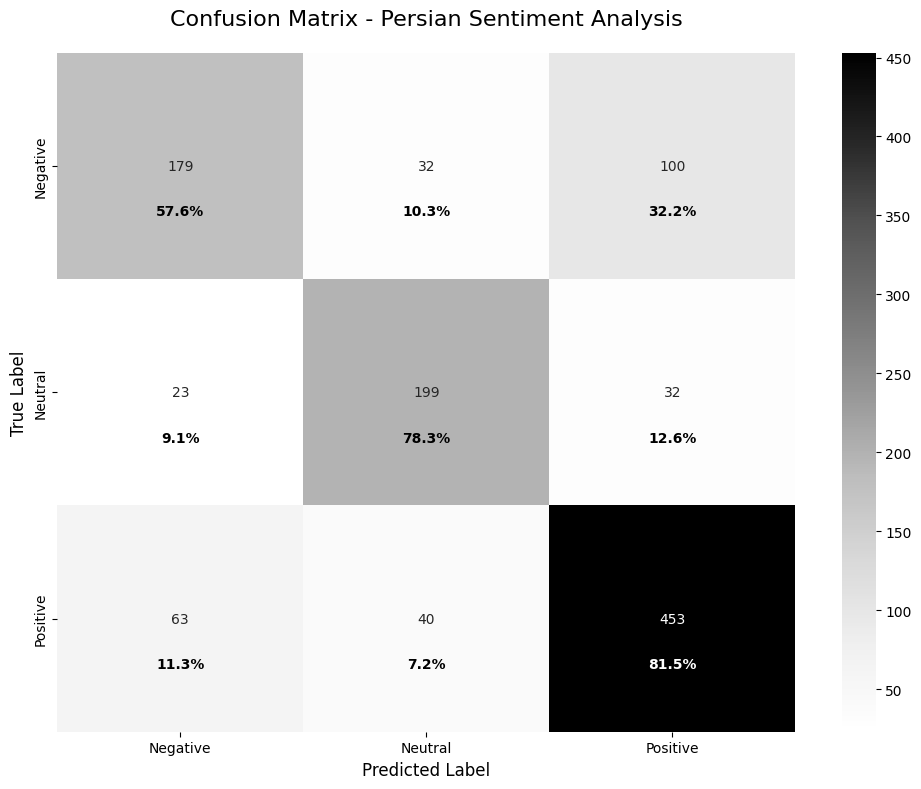

In [6]:
testVecX = vectorizer.transform(xtest)
yPred = svm.predict(testVecX)

# uniqure_lables = np.unique(ytest)
# print(uniqure_lables)
cm = confusion_matrix(ytest, yPred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Grays',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - Persian Sentiment Analysis', fontsize=16, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

for i in range(3):
    for j in range(3):
        total = np.sum(cm[i, :])
        percentage = (cm[i, j] / total) * 100
        plt.text(j+0.5, i+0.7, f'{percentage:.1f}%', 
                ha='center', va='center', 
                color='white' if cm[i, j] > 200 else 'black', 
                fontsize=10, fontweight='bold')

plt.tight_layout()
# plt.savefig('confusion_matrix_detailed.png', dpi=300, bbox_inches='tight')
plt.show()


# Misclassification Analysis


In [ ]:
xtestVec = vectorizer.transform(xtest)

yPred = svm.predict(xtestVec)

misclassified = xtest[ytest != yPred]
trueLabels    = ytest[ytest != yPred]
predLabels    = yPred[ytest != yPred]


misclassifiedDF = pd.DataFrame({
    "review": misclassified,
    "true_labels": trueLabels,
    "predicted_labels": predLabels
})



# Save misclassification
if Path("./analysis").is_dir():
    misclassifiedDF.to_csv(Path("./analysis/misclassification.csv"),index=False)
else:
    Path("./analysis").mkdir()
    misclassifiedDF.to_csv(Path("./analysis/misclassification.csv"),index=False)

# print("misclass shape: ",misclassified.shape)
# print("misclass shape: ",trueLabels.shape)
# print("misclass shape: ",predLabels.shape)

# Test on custome txt

In [38]:
testTXT = "کارت گرافیکی که خریدم واقعا حرف نداشت" 

resVEC = vectorizer.transform([testTXT])
polarity = svm.predict(resVEC)
print(polarity)

['positive']


# Export vocab

In [ ]:
with open("vocab.txt", mode="w", encoding='utf-8') as f:
        for i, word in enumerate(vectorizer.get_feature_names_out()):
                f.write(f"{i}: {word}\n")

# Save Model

In [40]:
joblib.dump(svm,        "svm_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']